In [1]:
import sys
import os
import dill
import glob
import json
import random
import argparse
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../../mats")
from tqdm import tqdm, trange
from model.model_registrar import ModelRegistrar
from model.mats import MATS
from environment.node import MultiNode
from model.dataset import EnvironmentDataset
import evaluation
import visualization

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [2]:
def load_model(model_dir, env, ts=100):
    model_registrar = ModelRegistrar(model_dir, 'cpu')
    model_registrar.load_models(ts)
    with open(os.path.join(model_dir, 'config.json'), 'r') as config_json:
        hyperparams = json.load(config_json)

    mats = MATS(model_registrar, hyperparams, None, 'cpu')
    return mats, hyperparams

In [3]:
def load_latest_model(model_dir, env):
    latest_model_path = sorted(glob.glob(os.path.join(model_dir, '*.pt')))[-1]
    latest_model_iter = int(latest_model_path.split('-')[-1].split('.')[0])
    return load_model(model_dir, env, ts=latest_model_iter)

In [4]:
with open('../processed/particles_test_2_robot.pkl', 'rb') as f:
    env = dill.load(f, encoding='latin1')

# Model Loading

In [5]:
mats, hyperparams = load_model('models/models_18_Jun_2020_22_02_19_2_zeroRrows_A_slew0p001', env)


Loading from models/models_18_Jun_2020_22_02_19_2_zeroRrows_A_slew0p001/model_registrar-100.pt
Loaded!



In [6]:
for attention_radius_override in hyperparams['override_attention_radius']:
    node_type1, node_type2, attention_radius = attention_radius_override.split(' ')
    env.attention_radius[(node_type1, node_type2)] = float(attention_radius)

if env.robot_type is None and hyperparams['incl_robot_node']:
    env.robot_type = env.NodeType[0]  # TODO: Make more general, allow the user to specify?
    for scene in env.scenes:
        scene.add_robot_from_nodes(env.robot_type,
                                   hyperparams=hyperparams,
                                   min_timesteps=hyperparams['minimum_history_length'] + 1 + hyperparams[
                                       'prediction_horizon'])

In [7]:
mats.set_environment(env)
mats.set_annealing_params()

In [8]:
scenes = env.scenes

for scene in tqdm(scenes):
    scene.calculate_scene_graph(env.attention_radius,
                                hyperparams['edge_addition_filter'],
                                hyperparams['edge_removal_filter'])

ph = hyperparams['prediction_horizon'] + 4
max_hl = hyperparams['maximum_history_length']

100%|██████████| 199/199 [00:00<00:00, 850.99it/s]


In [9]:
# Good ones are: 4, 5, 6, 12, 15, 16, 26, 27, 28, 29, 
# All at timestep: 8
scene = scenes[4] #np.random.choice(scenes)
timestep = np.array([8]) #scene.sample_timesteps(1, min_future_timesteps=ph, min_history_length=max_hl)

# print('Scene:', scenes.index(scene))
# print('Timestep:', timestep)

mats_outputs = list()
with torch.no_grad():
    mats_outputs.append(mats.predict(scene,
                                                 timestep,
                                                 ph,
                                                 min_future_timesteps=ph,
                                                 include_B=hyperparams['include_B'],
                                                 zero_R_rows=hyperparams['zero_R_rows']))

# Plotting

100%|██████████| 1/1 [00:00<00:00, 28.54it/s]


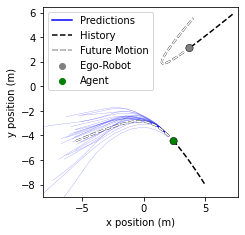

In [10]:
import matplotlib.patheffects as pe

fig, axes = plt.subplots(ncols=len(mats_outputs), 
                         figsize=(len(mats_outputs)*3.5, 3.5))
for idx in trange(len(mats_outputs)):    
    pred_dists, non_rob_rows, As, Bs, Qs, _, state_lengths_in_order = mats_outputs[idx]
    
    # Plot predicted timestep for random scene
    visualization.visualize_prediction(axes,
                                       pred_dists,
                                       scene.dt,
                                       max_hl=max_hl,
                                       ph=ph,
                                       map=scene.map['VISUALIZATION'] if scene.map is not None else None,
                                       robot_node=scene.robot)
    
    axes.set_xlabel(r'x position (m)')
    axes.set_ylabel(r'y position (m)')
    
    axes.set_xlim(left=-8, right=7.5)
    axes.set_ylim(bottom=-9, top=6.5)
    
    axes.scatter([], [], c='gray', label='Ego-Robot')
    axes.scatter([], [], c='green', label='Agent')
    axes.plot([], [], c='blue', label='Predictions')
    axes.plot([], [], ls='--', c='k', label='History')
    axes.plot([], [], ls='--', c='w',
              path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()], 
              label='Future Motion')
    axes.legend(loc='best')
    
# fig.savefig('plots/2_robotized_nice/scene_predictions.pdf', dpi=300, bbox_inches='tight')

100%|██████████| 1/1 [00:00<00:00, 36.06it/s]


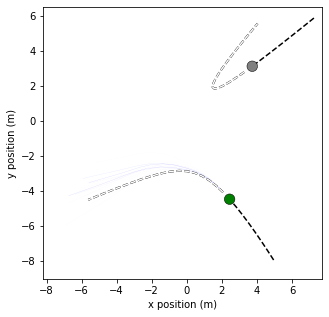

In [11]:
fig, axes = plt.subplots(ncols=len(mats_outputs), 
                         figsize=(len(mats_outputs)*5, 5))
for idx in trange(len(mats_outputs)):    
    pred_dists, non_rob_rows, As, Bs, Qs, _, state_lengths_in_order = mats_outputs[idx]
    
    # Plot predicted timestep for random scene
    visualization.visualize_prediction(axes,
                                       pred_dists,
                                       scene.dt,
                                       max_hl=max_hl,
                                       ph=ph,
                                       map=scene.map['VISUALIZATION'] if scene.map is not None else None,
                                       robot_node=scene.robot,
                                       pi_alpha=True)
    
    axes.set_xlabel(r'x position (m)')
    axes.set_ylabel(r'y position (m)')
    
    axes.set_xlim(left=-8, right=7.5)
    axes.set_ylim(bottom=-9, top=6.5)

# fig.savefig('plots/2_robotized_nice/scene_predictions_pi_weighted.pdf', dpi=300, bbox_inches='tight')

100%|██████████| 1/1 [00:00<00:00, 130.82it/s]


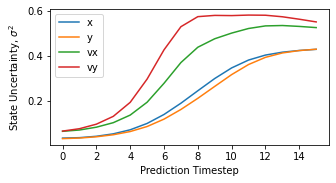

In [12]:
# Plotting uncertainty vs prediction horizon
fig, axes = plt.subplots(ncols=len(mats_outputs), 
                         figsize=(len(mats_outputs)*5, 2.5),
                         sharey=True)
for idx in trange(len(mats_outputs)):    
    pred_dists, non_rob_rows, As, Bs, Qs, _, state_lengths_in_order = mats_outputs[idx]
    
    random_dist = next(iter(pred_dists[timestep.item()].values()))
    pis = random_dist.pis
    ml_pi_idx = torch.argmax(pis).item()

    Q = Qs[0]

    for state in range(4, Q.shape[-1], 4):
        axes.plot(Q[:, 0, ml_pi_idx, state], label='x')
        axes.plot(Q[:, 0, ml_pi_idx, state+1], label='y')
        axes.plot(Q[:, 0, ml_pi_idx, state+2], label='vx')
        axes.plot(Q[:, 0, ml_pi_idx, state+3], label='vy')
    
    axes.legend(loc='best');
    axes.set_xlabel('Prediction Timestep');
    axes.set_ylabel(r'State Uncertainty, $\sigma^2$');
    
# fig.savefig('plots/2_robotized_nice/C_entries_vs_time.pdf', dpi=300, bbox_inches='tight')

In [13]:
def visualize_mat(mat, pred_dists, state_lengths_in_order, ax):
    timesteps, num_samples, components = mat.shape[:3]
    
    random_dist = next(iter(pred_dists.values()))
    pis = random_dist.pis
    ml_pi_idx = torch.argmax(pis).item()
    
    line_locs = state_lengths_in_order.cumsum(1)
    
    sns.heatmap(mat[0, 0, ml_pi_idx].cpu(),
                vmin=-0.20, center=0.00, vmax=0.20, cmap='coolwarm',
                annot=True, cbar=False, square=True,
                fmt=".2f", ax=ax)
#     ax.set_title('P(z=%d | x) = %.2f' % (ml_pi_idx, pis[ml_pi_idx]))
    ax.hlines(line_locs, *(ax.get_xlim()), colors=['white'], linewidths=3)
    ax.vlines(line_locs, *(ax.get_ylim()), colors=['white'], linewidths=3)
    ax.axis('off')

100%|██████████| 3/3 [00:00<00:00,  8.13it/s]


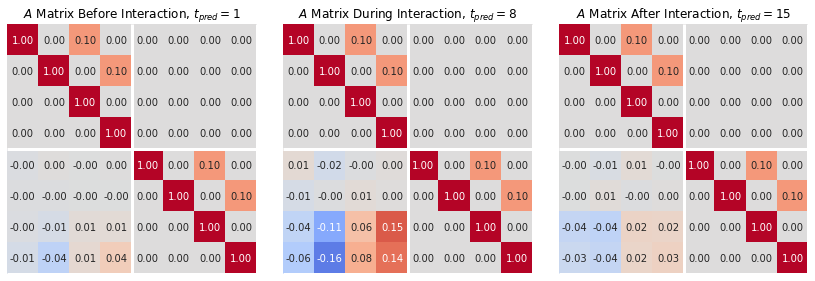

In [14]:
# Plot most-likely A matrices across time.
ph = hyperparams['prediction_horizon']
fig, axes = plt.subplots(ncols=3, 
                         figsize=(3*3.8, 3.8))

for idx in range(len(mats_outputs)):
    pred_dists, _, As, _, _, _, state_lengths_in_order = mats_outputs[idx]
    for i, ts in enumerate(tqdm([0, 7, 14])):
        visualize_mat(As[0][[ts]], pred_dists[timestep.item()], state_lengths_in_order, axes[i])
        
        title_str = axes[i].get_title()
#         axes[i].set_title(f"Prediction Timestep: {ts+1}");
        axes[i].set_title([f'$A$ Matrix Before Interaction, $t_{{pred}} = {{{ts+1}}}$',
                           f'$A$ Matrix During Interaction, $t_{{pred}} = {{{ts+1}}}$',
                           f'$A$ Matrix After Interaction, $t_{{pred}} = {{{ts+1}}}$'][i])
        
fig.tight_layout(pad=-0.5)
# fig.savefig(f'plots/2_robotized_nice/ml_A_mats_vs_time.pdf', dpi=300, bbox_inches='tight')